In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
#from scipy.stats import pearsonr

DATA PREPARATION

In [79]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code")
df=data_df.loc[1:90,["year", "coal_gen", "gas_gen", "price_gas", "price_brent","open_interest_gas","ets"]] 
print(df)

              year  coal_gen  gas_gen  price_gas  price_brent  \
1   Quarter 2 1998   27.1609  26.3784  13.011204    18.739496   
2   Quarter 3 1998   25.9900  27.5545  19.397759    20.560224   
3   Quarter 4 1998   30.2032  32.6438  16.545961    14.665738   
4   Quarter 1 1999   29.1229  35.9817  12.819444    21.166667   
5   Quarter 2 1999   21.5152  32.0022  13.645117    24.085282   
..             ...       ...      ...        ...          ...   
86  Quarter 3 2019    0.7038  28.0612  39.907579    56.173752   
87  Quarter 4 2019    2.5371  32.9864  28.662362    60.885609   
88  Quarter 1 2020    3.1276  26.2814  15.050691    20.958525   
89  Quarter 2 2020    0.3612  22.1984  14.921803    37.856486   
90  Quarter 3 2020    0.5076  29.6927  33.913841    37.534372   

    open_interest_gas        ets  
1                 875        NaN  
2                3360        NaN  
3                6490        NaN  
4                2425        NaN  
5                2455        NaN  
..       

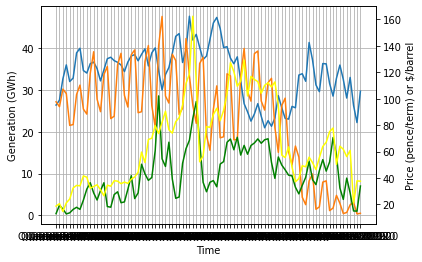

In [80]:
plt.plot(df.year, df.gas_gen)
plt.plot(df.year, df.coal_gen)
plt.xlabel("Time")
plt.ylabel("Generation (GWh)")
plt.grid()
plt2=plt.twinx()
plt2.plot(df.year, df.price_gas, color="green")
plt2.plot(df.year, df.price_brent, color="yellow")
plt2.set_ylabel("Price (pence/term) or $/barrel", color="black")
#plt.ylabel
plt.show()

In [81]:
#Vector:
dcoal=df.coal_gen
dgas=df.gas_gen
dprice_gas=df.price_gas
dprice_brent=df.price_brent
dOI=df.open_interest_gas
dETS=df.ets

DataSeries=[dcoal,dgas,dprice_gas, dprice_brent,dOI,dETS]
#DataSeries=[dcoal,dgas,dprice_gas]

In [82]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary
from statsmodels.tsa.stattools import adfuller, kpss
for df in DataSeries:
    print ('Results of Dickey-Fuller Test for:',df.name)
    dftest = adfuller(df, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    print ('Results of KPSS Test for:', df.name)
    kpsstest = kpss(df, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# normal distribution of residuals 



Results of Dickey-Fuller Test for: coal_gen
Test Statistic                  0.188754
p-value                         0.971624
#Lags Used                      6.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64
Results of KPSS Test for: coal_gen
Test Statistic           1.02494
p-value                  0.01000
#Lags Used               5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64
Results of Dickey-Fuller Test for: gas_gen
Test Statistic                 -1.745105
p-value                         0.408036
#Lags Used                      2.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64
Results of KPSS Test for: ga

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


MissingDataError: exog contains inf or nans

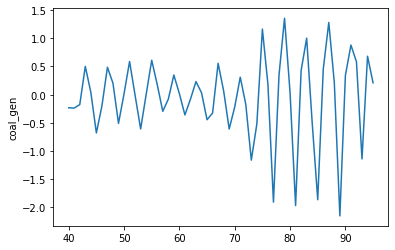

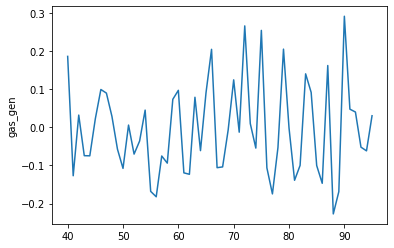

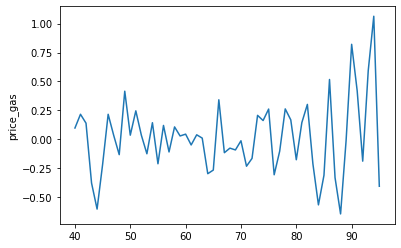

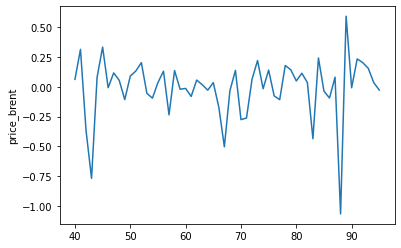

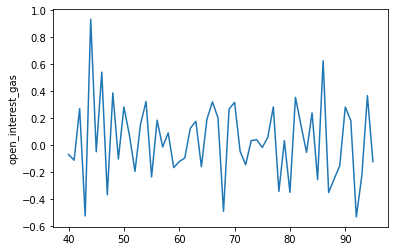

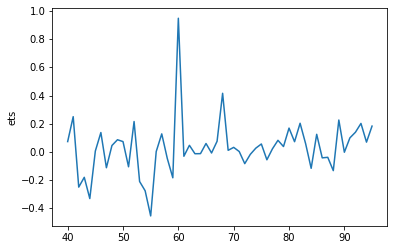

In [ ]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

DataSeriesCorr=[]
for df in DataSeries:
    df_log = pd.Series(np.log(df))
    df_diff = df_log.diff().dropna()
    plt.plot(df_diff)
    plt.ylabel(df.name)
    plt.show()
    DataSeriesCorr.append(df_diff)

DataSeries = DataSeriesCorr

In [ ]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary
from statsmodels.tsa.stattools import adfuller, kpss
for df in DataSeries:
    print ('Results of Dickey-Fuller Test for:',df.name)
    dftest = adfuller(df, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    print ('Results of KPSS Test for:', df.name)
    kpsstest = kpss(df, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

# normal distribution of residuals 



Results of Dickey-Fuller Test for: coal_gen
Test Statistic                 -2.083293
p-value                         0.251285
#Lags Used                      5.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
Results of KPSS Test for: coal_gen
Test Statistic            0.115469
p-value                   0.100000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test for: gas_gen
Test Statistic                -7.229878e+00
p-value                        2.007598e-10
#Lags Used                     1.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: f

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

In [ ]:
def plot_gen(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='red')
    plt.grid()
    plt.ylabel('Generation output (GWh)', fontsize=16)

def plot_price(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='green')
    plt.grid()
    plt.ylabel('Price p/term', fontsize=16)

def plot_basic(series, name):
    plt.figure(figsize=(9,4))
    plt.plot(series)
    plt.ylabel(name, fontsize=10)
    plt.grid()


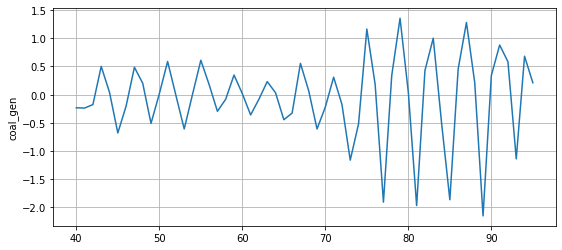

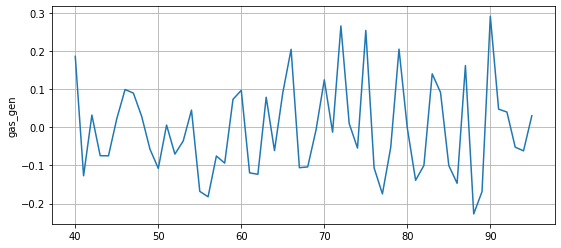

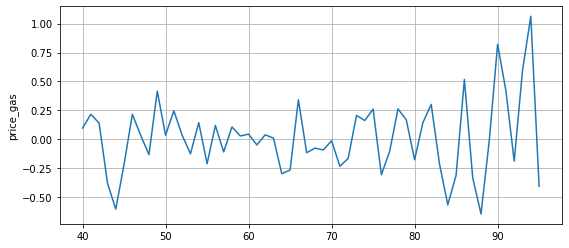

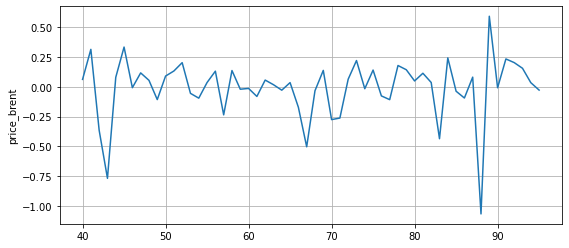

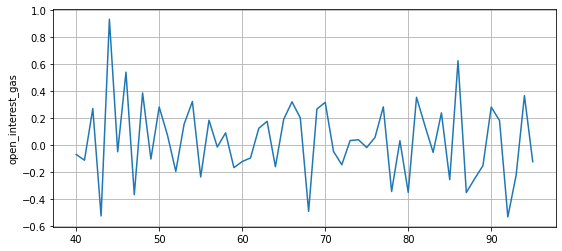

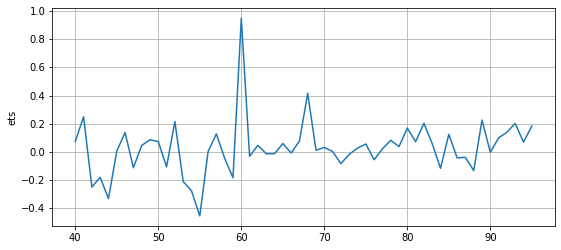

In [ ]:
for df in DataSeries:
#    avg, dev = df.mean(), df.std()
#    df = (df - avg)/dev
    plot_basic(df, df.name)



Remove seasonality: (quaterly or monthly)

Remove volatility: (lower timeframes)

Remove heteroscedadicity:

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


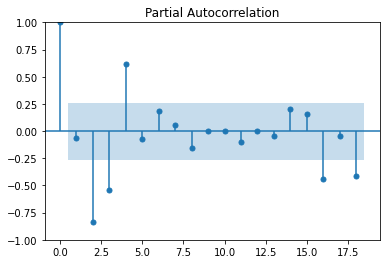

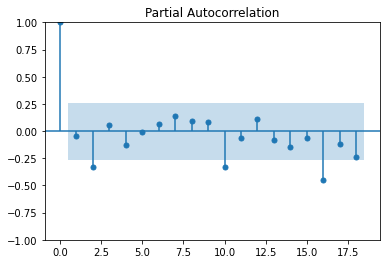

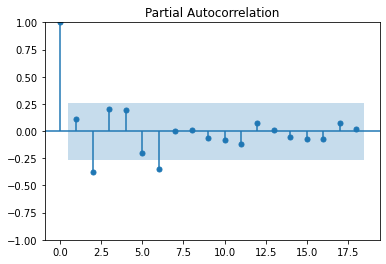

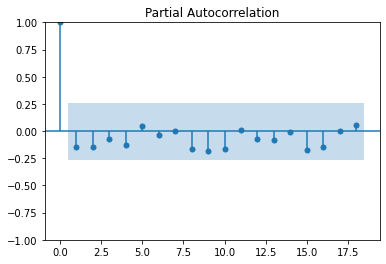

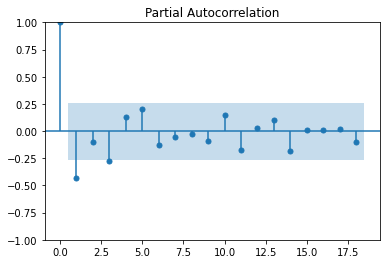

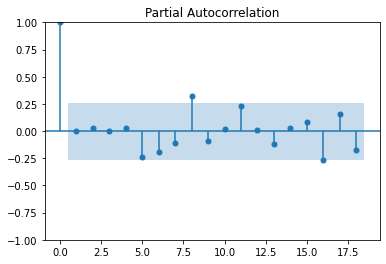

In [ ]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()



# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()




    coal_gen   gas_gen  price_gas  price_brent  open_interest_gas       ets
40 -0.235193  0.185651   0.097877     0.061723          -0.070151  0.072697
41 -0.239995 -0.127199   0.216567     0.313504          -0.112760  0.249788
42 -0.177964  0.031799   0.139597    -0.365274           0.270830 -0.250737
43  0.501260 -0.074582  -0.377313    -0.768160          -0.526321 -0.181208
44  0.039886 -0.074954  -0.602445     0.079111           0.933494 -0.332161
45 -0.682665  0.022310  -0.216239     0.332788          -0.050160  0.005541
46 -0.204376  0.098892   0.216518    -0.007870           0.540765  0.136991
47  0.486023  0.089411   0.034791     0.116166          -0.368244 -0.113069
48  0.201437  0.028356  -0.132235     0.053781           0.386488  0.044873
49 -0.512558 -0.057622   0.415958    -0.107648          -0.103982  0.085883
50  0.013777 -0.107883   0.036113     0.089543           0.282203  0.072752
51  0.588012  0.005606   0.246267     0.131929           0.072494 -0.106357
52 -0.014848

/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


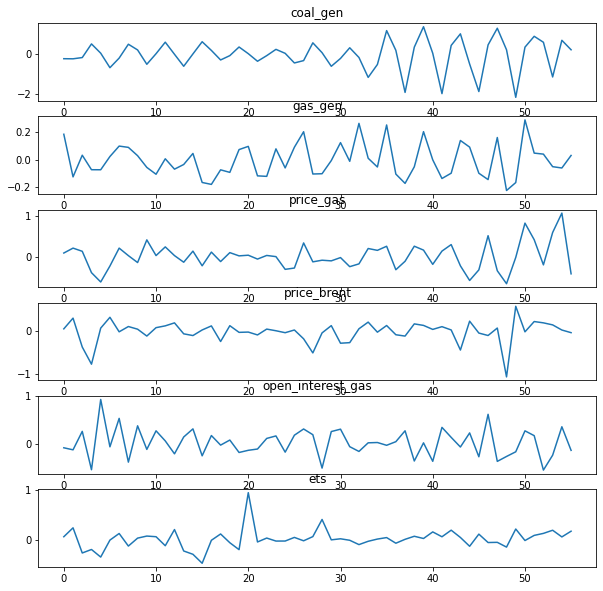

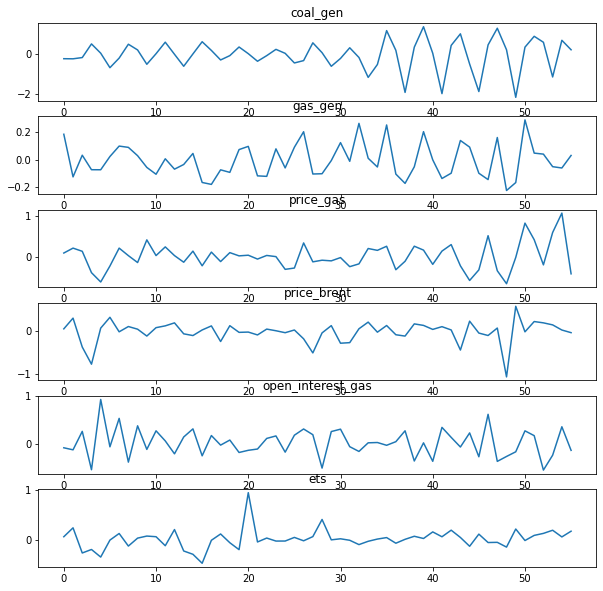

In [ ]:
S=[]

for df in DataSeries:
    dframe = df.to_frame()
    S.append(dframe)

#print(type(dfcoal))
#print(dfcoal.describe())
#print(dfprice.describe())


gen_price_df = pd.concat(S, axis=1)
print(gen_price_df)

model = VAR(gen_price_df)
model_fit = model.fit(maxlags=5, ic="aic") #aic, or bic
model_fit.summary()

model_fit.plot()


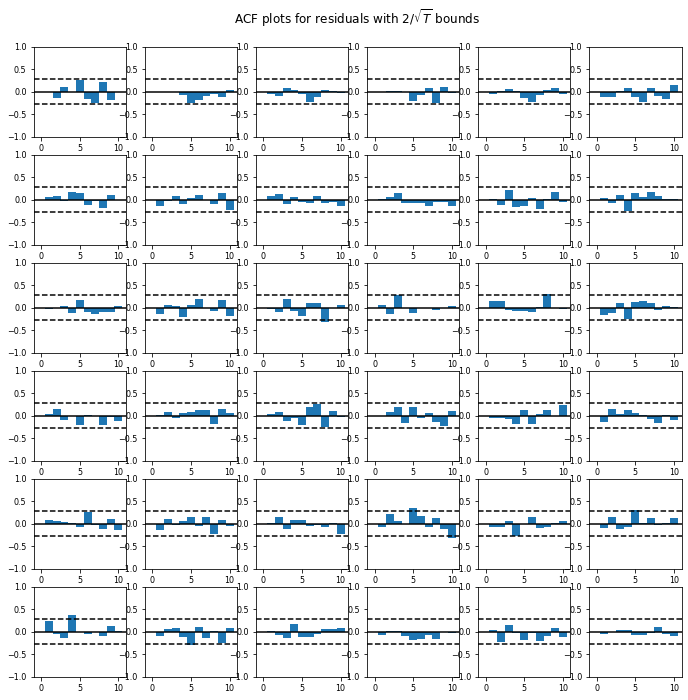

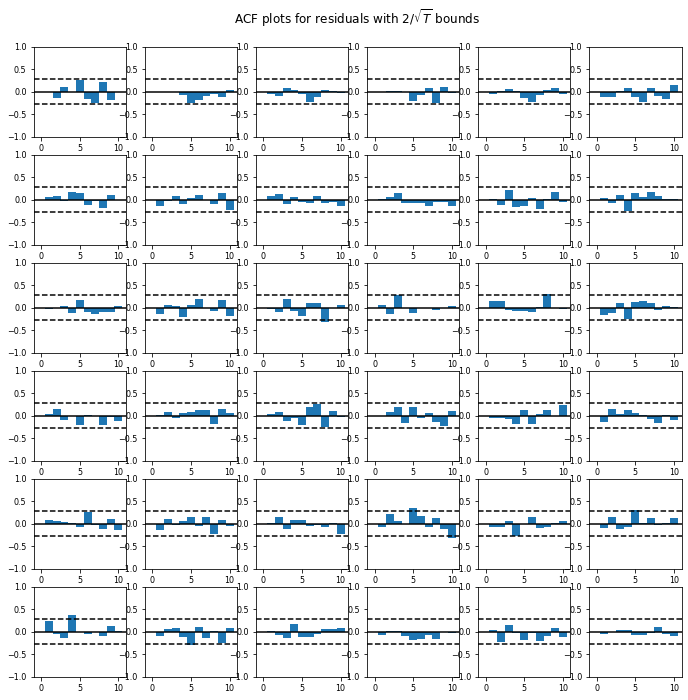

In [ ]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
model_fit.plot_acorr()

In [ ]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('price_gas', ['price_brent'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: price_brent does not Granger-cause price_gas. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.123          2.290   0.067 (5, 120)
----------------------------------------------


FEVD for coal_gen
      coal_gen   gas_gen  price_gas  price_brent  open_interest_gas       ets
0     1.000000  0.000000   0.000000     0.000000           0.000000  0.000000
1     0.763590  0.000095   0.103435     0.028885           0.078935  0.025061
2     0.696150  0.044030   0.132776     0.031898           0.075758  0.019388
3     0.654697  0.086556   0.120599     0.042149           0.074044  0.021956
4     0.684002  0.079984   0.091149     0.065916           0.063602  0.015348
5     0.661511  0.107101   0.080706     0.059294           0.074514  0.016873
6     0.633876  0.109917   0.080031     0.067181           0.093402  0.015592
7     0.596260  0.118667   0.079142     0.080075           0.102512  0.023344
8     0.654634  0.090180   0.067963     0.074707           0.094782  0.017733
9     0.660688  0.080340   0.061377     0.066558           0.114255  0.016782
10    0.649517  0.078563   0.073679     0.065446           0.116268  0.016527
11    0.622248  0.083010   0.070525     0.0729

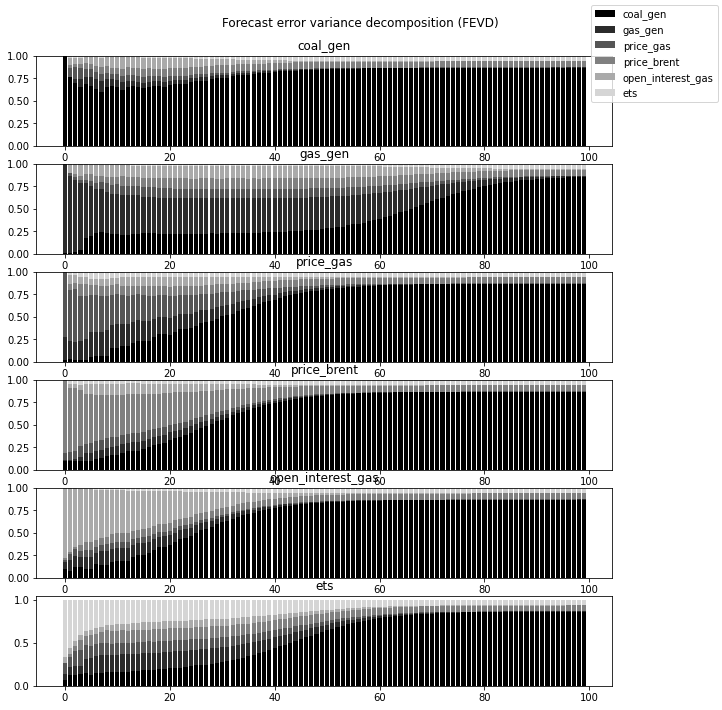

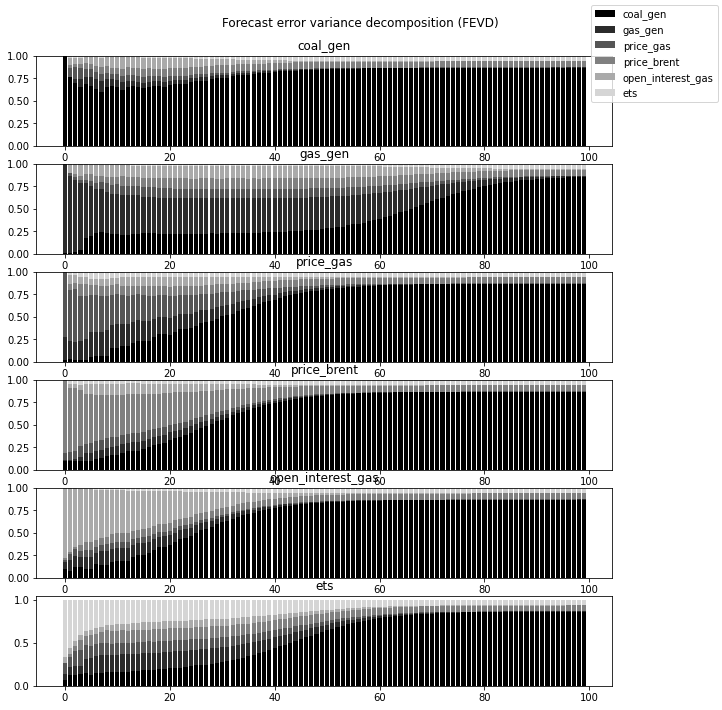

In [ ]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 5 periods
fevd = model_fit.fevd(20)
fevd.summary()


#affichage pour n périodes
model_fit.fevd(100).plot()

IMPULSE RESPONSE ANALYSIS:

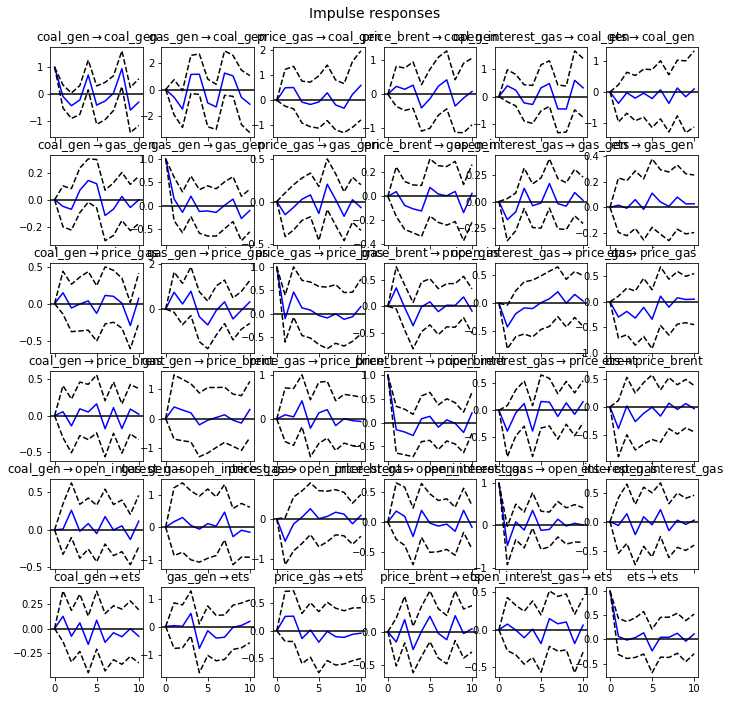

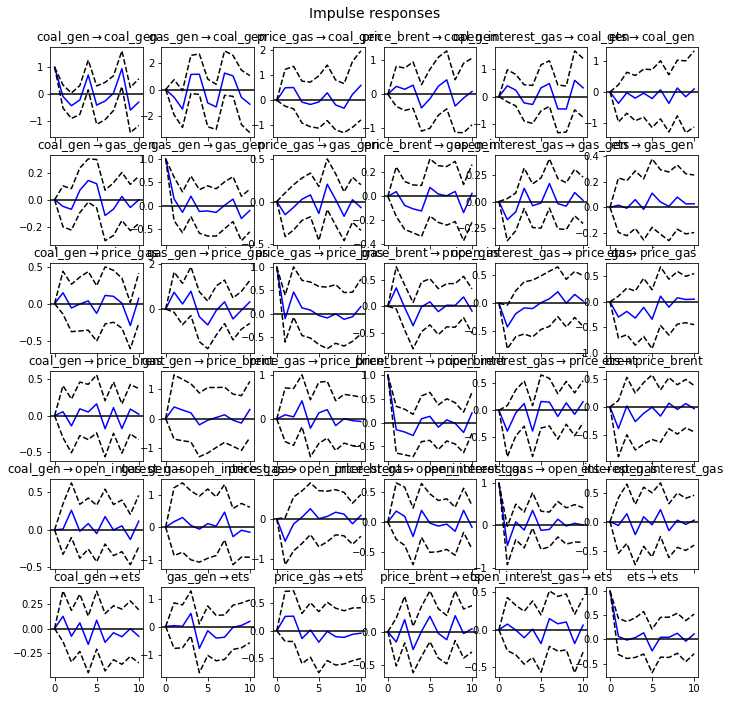

In [ ]:
irf = model_fit.irf(10)
irf.plot(orth=False)